In [1]:
using BSON: @save
using BSON: @load
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy, BatchNorm
using Flux.Data: DataLoader
using Flux: chunk
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets
using Images
using ImageIO
using LinearAlgebra
using FFTW

using NBInclude
@nbinclude("src/functions.ipynb")

All function imported


In [2]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [23]:
function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST(split=:train)[:]
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder 
    end
    println("Done")
end

function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784,500, relu),
        Dense(500,500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))
    
    decoder = Chain(
        Dense(20, 500, relu, bias = false),
        Dense(500,500, relu, bias = false),
        Dense(500, 784, relu, bias = false)
    )

    return encoder_μ, encoder_logvar, decoder
end

create_vae (generic function with 1 method)

In [29]:
function vae_loss(encoder_μ, encoder_logvar, decoder, x, β, λ, F_sub, m)
    batch_size = size(x)[end]
    @assert batch_size != 0

    y_sub = F_sub*x
    y = vcat(y_sub, zeros(784-m, batch_size))

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(y)
    logvar = encoder_logvar(y)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ =  decoder(z)
    
    # # Negative reconstruction loss Ε_q[logp_x_z]
    # logp_x_z = -sum(binarycrossentropy.(x̂, x)) 

    # mismatch MSE
    MSE = (norm(y_sub - F_sub*x̂, 2)^2)/m

    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) 
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar))
    # We want to maximise the evidence lower bound (ELBO)
    elbo =  - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty
    return -elbo + reg + MSE
end

function train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar)
    progress_tracker = Progress(num_epochs, "Training a epoch done")

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        loss = 0
        for (x_batch, y_batch) in dataloader
            m = rand(1:784)
            F_sub = sample_fourier(m, 784)

            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, x_batch, β, λ, F_sub, m)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
        end
        next!(progress_tracker; showvalues=[(:loss, loss)])
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        # println(metrics)
        CSV.write(joinpath(save_dir, "metrics.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, save_dir, epoch_num)
    end
    println("Training complete!")
end



train (generic function with 2 methods)

In [90]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.01f0
num_epochs = 100
save_dir = "trained_GNN/test/trained_GNN/MNIST_ML"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data)
# encoder_μ, encoder_logvar, decoder = create_vae()
train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, ADAM(η), save_dir)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\Babhru\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Training a epoch done 100%|██████████████████████████████| Time: 3:11:27
  loss:  6.760167043171348


Saving model...Done
Training complete!


In [31]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST(split=:test)[:]
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    @assert num_images <= size(x_batch)[2]
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(x_batch[:, i], 28,28)' ))
    end
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample

    x̂ = sigmoid(decoder(z))
    return clamp.(x̂, 0 ,1)
end

function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function visualise()
    # Define some parameters
    batch_size = 1
    shuffle = true
    num_images = 1
    epoch_to_load = 20
    # Load the model and test set loader
    dir = "test/trained_GNN/MNIST_sigmoid_inco"
    encoder_μ, encoder_logvar, decoder= load_model_identity(dir, epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, dir, "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
        print(size(x_batch))
        save_to_images(x̂_batch, dir, "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [ ]:
visualise()

In [ ]:
load("test/trained_GNN/MNIST_sigmoid_inco/reconstruction-1.png")

In [ ]:
load("test/trained_GNN/MNIST_sigmoid_inco/test-image-1.png")

In [32]:
using NBInclude
@nbinclude("src/functions.ipynb")
epoch_to_load =10
# Load the model and test set loader
dir = "trained_GNN/test/trained_GNN/MNIST_ML"
encoder_μ, encoder_logvar, decoder = load_model_identity(dir, epoch_to_load);


batch_size = 64; shuffle = true
dataloader = get_test_loader(batch_size, shuffle)
(x_batch, y_batch) = first(dataloader)

# # x = reshape(x_batch[:,1], 784,1)

# μ = encoder_μ(x_batch)
# logvar = encoder_logvar(x_batch)
# # Apply reparameterisation trick to sample latent
# z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar);


# z1 = z[:,1]
# z2 = z[:,2]
# β = 1
# colorview(Gray,reshape(sigmoid(decoder(β * z2 + (1-β) *z1))[:,1], 28,28)')
# colorview(Gray,reshape(sigmoid(decoder(randn(20)))[:,1], 28,28)')






All function imported
Loading model...Done


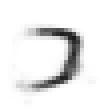

In [51]:
colorview(Gray, reshape(decoder(randn(20)), 28, 28)' )


In [88]:
m = rand(1:784)
F_sub = sample_fourier(m, 784)
y_sub = F_sub*x_batch
y = vcat(y_sub, zeros(784-m, batch_size))

# Forward propagate through mean encoder and std encoders
μ = encoder_μ(y)
logvar = encoder_logvar(y)
# Apply reparameterisation trick to sample latent
z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
# Reconstruct from latent sample
x̂ =  decoder(z)


784×64 Matrix{Float64}:
 0.999744  0.999999  0.999983  0.999998  …  0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998  …  0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998  …  0.999975  0.999947  0.999929
 0.999744  0.999999  0.999983  0.999998     0.999975  0.999947  0.999929
 0.999705  0.999999  0.999984  0.999998     0.999976  0.999937  0.999928
 ⋮                         

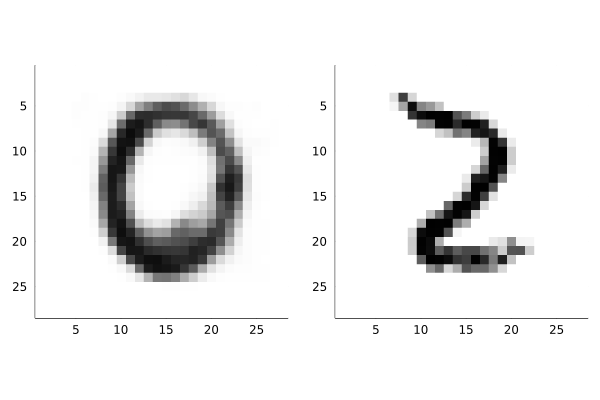

In [91]:
i = 1
p1 = plot(colorview(Gray, reshape(x̂[:,i], 28, 28)' ))
p2 = plot(colorview(Gray, reshape(x_batch[:,i], 28, 28)'))

plot(p1,p2, layout = grid(1,2))



In [92]:
m

659